In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pmd
import itertools # 用于网格搜索
from statsmodels.tsa.stattools import adfuller, acf, pacf,kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

In [15]:
FILE_PATH = './BTC_factors/addresses/BTC_1h_profit_relative.csv'
TARGET_COL = 'profit_relative'
df = pd.read_csv(FILE_PATH)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
cutoff_date = pd.to_datetime('2021-01-01')
df = df[df['datetime'] >= cutoff_date].copy()
df.set_index('datetime', inplace=True)
data = df[TARGET_COL].resample('1D').mean().dropna()
data = data.to_frame(name='y') 
n_obs = len(data)
train_size = int(0.8 * n_obs)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
print(train_data.tail())


                   y
datetime            
2024-07-14  0.857433
2024-07-15  0.884141
2024-07-16  0.911753
2024-07-17  0.928394
2024-07-18  0.919675


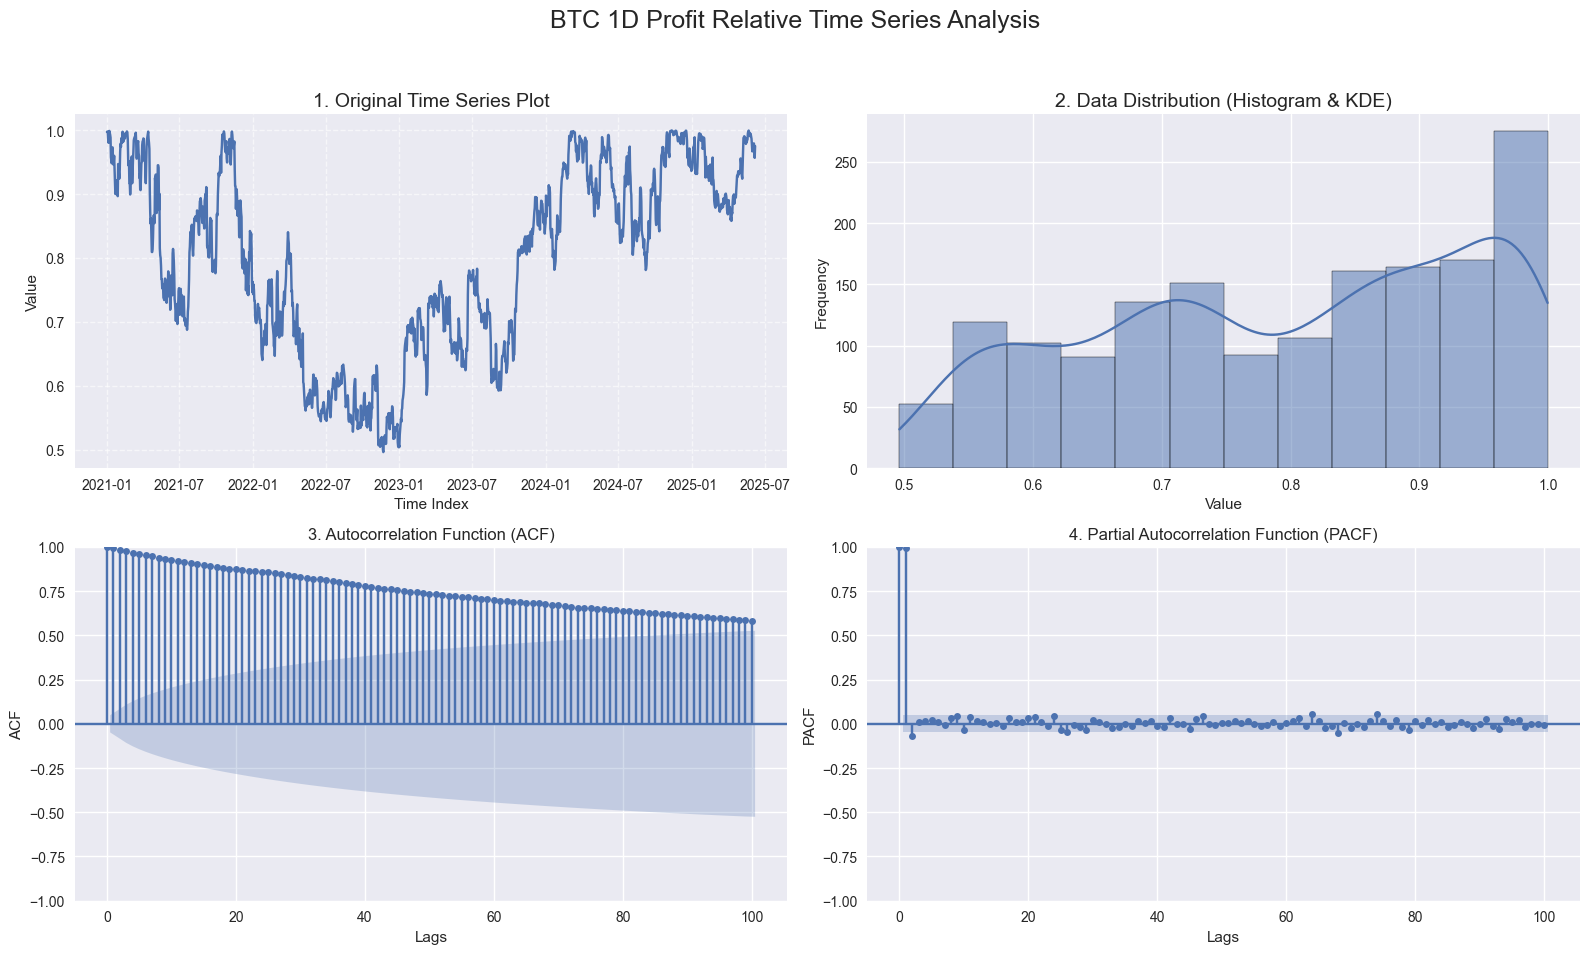

📈 時間序列平穩性檢驗報告 (Significance Level: 0.05)
### 1. ADF Test ###
  零假設 (H0): 序列 非平穩 (存在單位根)
  ADF Statistic: -2.521583
  P-Value: 0.110311
  Critical Values:
    1% (-3.4344)
    5% (-2.8633)
    10% (-2.5677)
  ▶️ 結論: 序列 非平穩 (Fail to Reject H0: Unit Root Exists)

### 2. KPSS Test ###
  零假設 (H0): 序列 平穩 (平穩於水平)
  KPSS Statistic: 1.663615
  P-Value: 0.010000
  Critical Values:
    10% (0.3470)
    5% (0.4630)
    2.5% (0.5740)
    1% (0.7390)
  ▶️ 結論: 序列 非平穩 (Reject H0: Not Stationary)

------------------------------------------------------------
✅ 綜合判斷: 強烈證據：序列是非平穩的 (Strong evidence: Non-Stationary)
------------------------------------------------------------


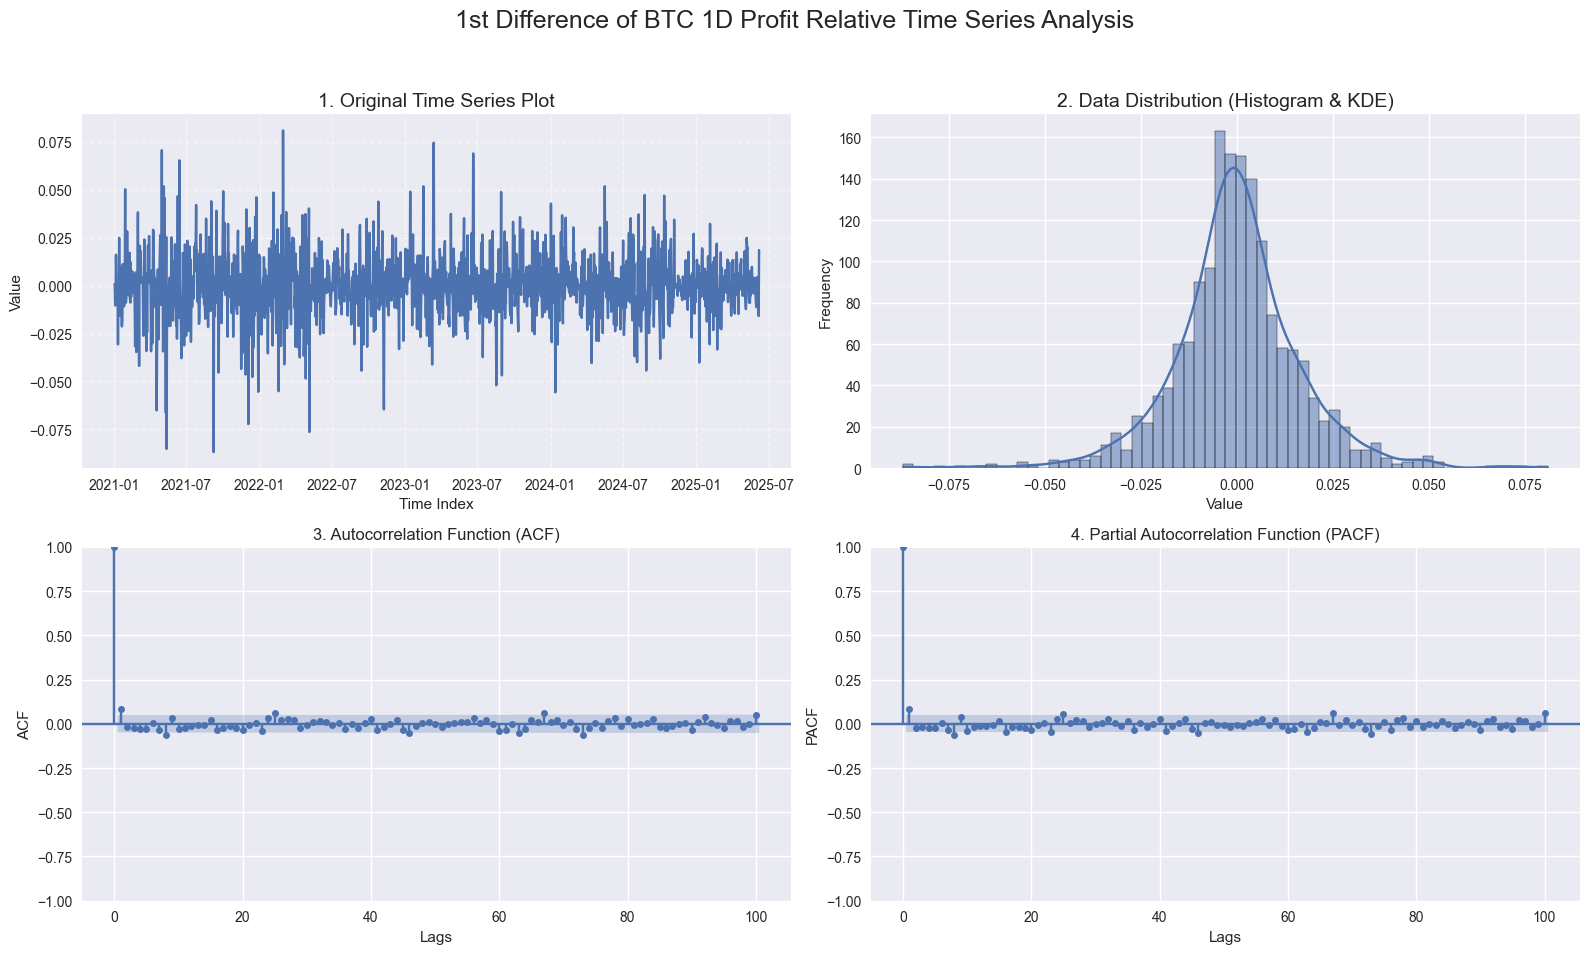

📈 時間序列平穩性檢驗報告 (Significance Level: 0.05)
### 1. ADF Test ###
  零假設 (H0): 序列 非平穩 (存在單位根)
  ADF Statistic: -36.880357
  P-Value: 0.000000
  Critical Values:
    1% (-3.4344)
    5% (-2.8633)
    10% (-2.5677)
  ▶️ 結論: 序列 平穩 (Reject H0: No Unit Root)

### 2. KPSS Test ###
  零假設 (H0): 序列 平穩 (平穩於水平)
  KPSS Statistic: 0.131432
  P-Value: 0.100000
  Critical Values:
    10% (0.3470)
    5% (0.4630)
    2.5% (0.5740)
    1% (0.7390)
  ▶️ 結論: 序列 平穩 (Fail to Reject H0: Stationary)

------------------------------------------------------------
✅ 綜合判斷: 強烈證據：序列是平穩的 (Strong evidence: Stationary)
------------------------------------------------------------


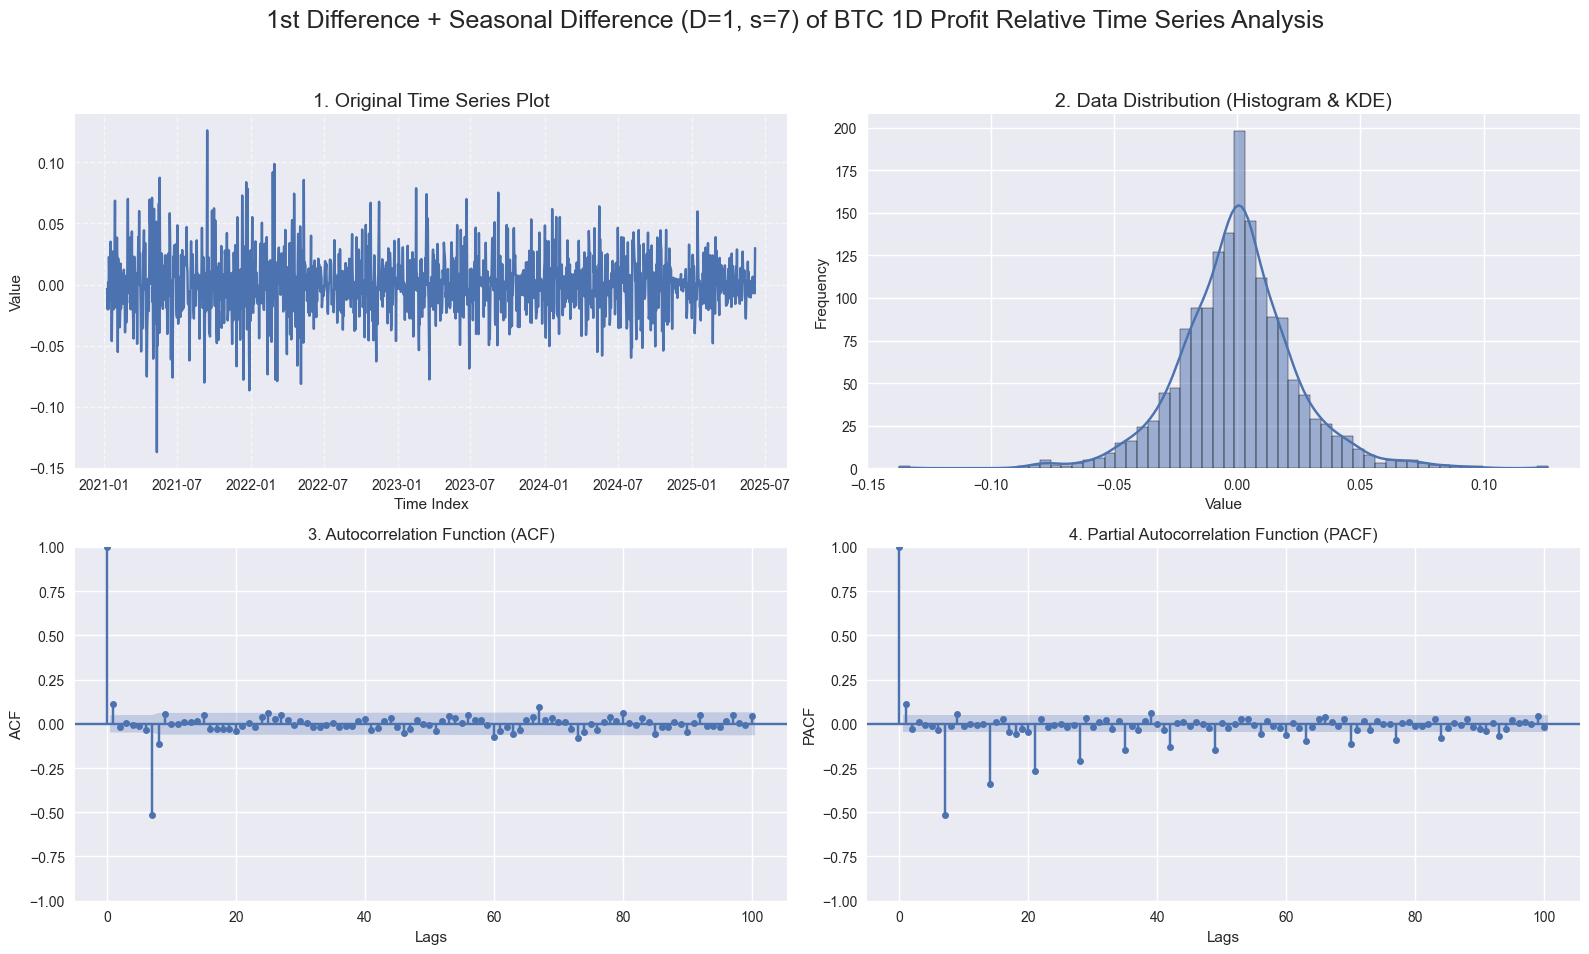

📈 時間序列平穩性檢驗報告 (Significance Level: 0.05)
### 1. ADF Test ###
  零假設 (H0): 序列 非平穩 (存在單位根)
  ADF Statistic: -17.229001
  P-Value: 0.000000
  Critical Values:
    1% (-3.4345)
    5% (-2.8634)
    10% (-2.5677)
  ▶️ 結論: 序列 平穩 (Reject H0: No Unit Root)

### 2. KPSS Test ###
  零假設 (H0): 序列 平穩 (平穩於水平)
  KPSS Statistic: 0.002228
  P-Value: 0.100000
  Critical Values:
    10% (0.3470)
    5% (0.4630)
    2.5% (0.5740)
    1% (0.7390)
  ▶️ 結論: 序列 平穩 (Fail to Reject H0: Stationary)

------------------------------------------------------------
✅ 綜合判斷: 強烈證據：序列是平穩的 (Strong evidence: Stationary)
------------------------------------------------------------


In [11]:
def plot_time_series_analysis(ts, lags=40, title_prefix='Time Series Analysis'):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'{title_prefix}', fontsize=18)
    
    # 1. 原始時間序列圖 (Top Left)
    axes[0, 0].plot(ts)
    axes[0, 0].set_title('1. Original Time Series Plot', fontsize=14)
    axes[0, 0].set_xlabel('Time Index')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. 數據分佈圖 (Histogram/KDE Plot) (Top Right)
    # 使用 seaborn 繪製帶核密度估計的直方圖
    sns.histplot(ts, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('2. Data Distribution (Histogram & KDE)', fontsize=14)
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')

    # 3. 自相關函數 (ACF) 圖 (Bottom Left)
    # 使用 statsmodels 的 plot_acf 函數，它會自動繪製置信區間
    # 關閉軸標籤，因為 plot_acf 會自己創建一個新的軸
    plot_acf(ts, lags=lags, ax=axes[1, 0], title='3. Autocorrelation Function (ACF)')
    axes[1, 0].set_xlabel('Lags')
    axes[1, 0].set_ylabel('ACF')

    # 4. 偏自相關函數 (PACF) 圖 (Bottom Right)
    # 使用 statsmodels 的 plot_pacf 函數
    plot_pacf(ts, lags=lags, ax=axes[1, 1], method='ywm', title='4. Partial Autocorrelation Function (PACF)')
    axes[1, 1].set_xlabel('Lags')
    axes[1, 1].set_ylabel('PACF')

    # 調整子圖之間的間距
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 為 suptitle 留出空間
    plt.show()

def run_stationarity_tests(timeseries, alpha=0.05):
    
    results = {}
    
    # --- 1. 增廣迪基-福勒檢驗 (ADF Test) ---
    # 零假設 H0: 存在單位根 (序列非平穩)
    adf_result = adfuller(timeseries, autolag='AIC')
    
    adf_statistic = adf_result[0]
    adf_p_value = adf_result[1]
    
    adf_conclusion = ""
    if adf_p_value <= alpha:
        # p-value <= alpha (例如 0.05)，拒絕 H0，序列平穩
        adf_conclusion = "平穩 (Reject H0: No Unit Root)"
        is_adf_stationary = True
    else:
        # p-value > alpha，無法拒絕 H0，序列非平穩
        adf_conclusion = "非平穩 (Fail to Reject H0: Unit Root Exists)"
        is_adf_stationary = False
    
    adf_details = {
        'Test': 'ADF',
        'H0': '非平穩 (存在單位根)',
        'Statistic': f'{adf_statistic:.6f}',
        'p-value': f'{adf_p_value:.6f}',
        'Critical Values': adf_result[4],
        'Lags Used': adf_result[2],
        'Conclusion': adf_conclusion
    }
    results['ADF'] = adf_details

    # --- 2. KPSS 檢驗 (KPSS Test) ---
    # 零假設 H0: 序列是平穩的 (與 ADF 相反)
    kpss_stat, kpss_p_value, kpss_lags, kpss_critical_values = kpss(
        timeseries, regression='c', nlags='auto'
    )
    
    kpss_conclusion = ""
    if kpss_p_value <= alpha:
        # p-value <= alpha (例如 0.05)，拒絕 H0，序列非平穩
        kpss_conclusion = "非平穩 (Reject H0: Not Stationary)"
        is_kpss_stationary = False
    else:
        # p-value > alpha，無法拒絕 H0，序列平穩
        kpss_conclusion = "平穩 (Fail to Reject H0: Stationary)"
        is_kpss_stationary = True
        
    kpss_details = {
        'Test': 'KPSS',
        'H0': '平穩 (平穩於水平)',
        'Statistic': f'{kpss_stat:.6f}',
        'p-value': f'{kpss_p_value:.6f}',
        'Critical Values': kpss_critical_values,
        'Lags Used': kpss_lags,
        'Conclusion': kpss_conclusion
    }
    results['KPSS'] = kpss_details

    # --- 3. 綜合結論 ---
    if is_adf_stationary and is_kpss_stationary:
        overall_conclusion = "強烈證據：序列是平穩的 (Strong evidence: Stationary)"
    elif (not is_adf_stationary) and (not is_kpss_stationary):
        overall_conclusion = "強烈證據：序列是非平穩的 (Strong evidence: Non-Stationary)"
    elif is_adf_stationary and (not is_kpss_stationary):
        overall_conclusion = "矛盾結果：可能為趨勢平穩 (Conflicting: Potentially Trend Stationary)"
    else: # (not is_adf_stationary) and is_kpss_stationary
        overall_conclusion = "矛盾結果：序列非平穩性較強 (Conflicting: Non-stationary tendency)"
        
    results['Overall_Conclusion'] = overall_conclusion
    
    return results

def print_stationarity_results(results_dict):
    """打印格式化後的檢驗結果。"""
    print("=" * 60)
    print(f"📈 時間序列平穩性檢驗報告 (Significance Level: 0.05)")
    print("=" * 60)
    
    # 打印 ADF 結果
    adf_res = results_dict['ADF']
    print(f"### 1. ADF Test ###")
    print(f"  零假設 (H0): 序列 {adf_res['H0']}")
    print(f"  ADF Statistic: {adf_res['Statistic']}")
    print(f"  P-Value: {adf_res['p-value']}")
    print(f"  Critical Values:")
    for key, value in adf_res['Critical Values'].items():
        print(f"    {key} ({value:.4f})")
    print(f"  ▶️ 結論: 序列 {adf_res['Conclusion']}\n")
    
    # 打印 KPSS 結果
    kpss_res = results_dict['KPSS']
    print(f"### 2. KPSS Test ###")
    print(f"  零假設 (H0): 序列 {kpss_res['H0']}")
    print(f"  KPSS Statistic: {kpss_res['Statistic']}")
    print(f"  P-Value: {kpss_res['p-value']}")
    print(f"  Critical Values:")
    for key, value in kpss_res['Critical Values'].items():
        print(f"    {key} ({value:.4f})")
    print(f"  ▶️ 結論: 序列 {kpss_res['Conclusion']}\n")
    
    # 打印綜合結論
    print("-" * 60)
    print(f"✅ 綜合判斷: {results_dict['Overall_Conclusion']}")
    print("-" * 60)
plot_time_series_analysis(data['y'], lags=100, title_prefix='BTC 1D Profit Relative Time Series Analysis')
stationarity_results = run_stationarity_tests(data['y'], alpha=0.05)
print_stationarity_results(stationarity_results)

diff_1_data = data['y'].diff().dropna()
plot_time_series_analysis(diff_1_data, lags=100, title_prefix='1st Difference of BTC 1D Profit Relative Time Series Analysis')
diff_1_stationarity_results = run_stationarity_tests(diff_1_data, alpha=0.05)
print_stationarity_results(diff_1_stationarity_results)

diff_1_seasonal_diff_data = diff_1_data.diff(7).dropna()
plot_time_series_analysis(diff_1_seasonal_diff_data, lags=100, 
                         title_prefix='1st Difference + Seasonal Difference (D=1, s=7) of BTC 1D Profit Relative Time Series Analysis')
diff_1_seasonal_stationarity_results = run_stationarity_tests(diff_1_seasonal_diff_data, alpha=0.05)
print_stationarity_results(diff_1_seasonal_stationarity_results)

C:\Windows\Temp\ipykernel_24896\4247514361.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_viz, x='DayOfWeek', y='Value', ax=ax3, palette="Set2")
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
C:\Users\30459\AppData\Loc

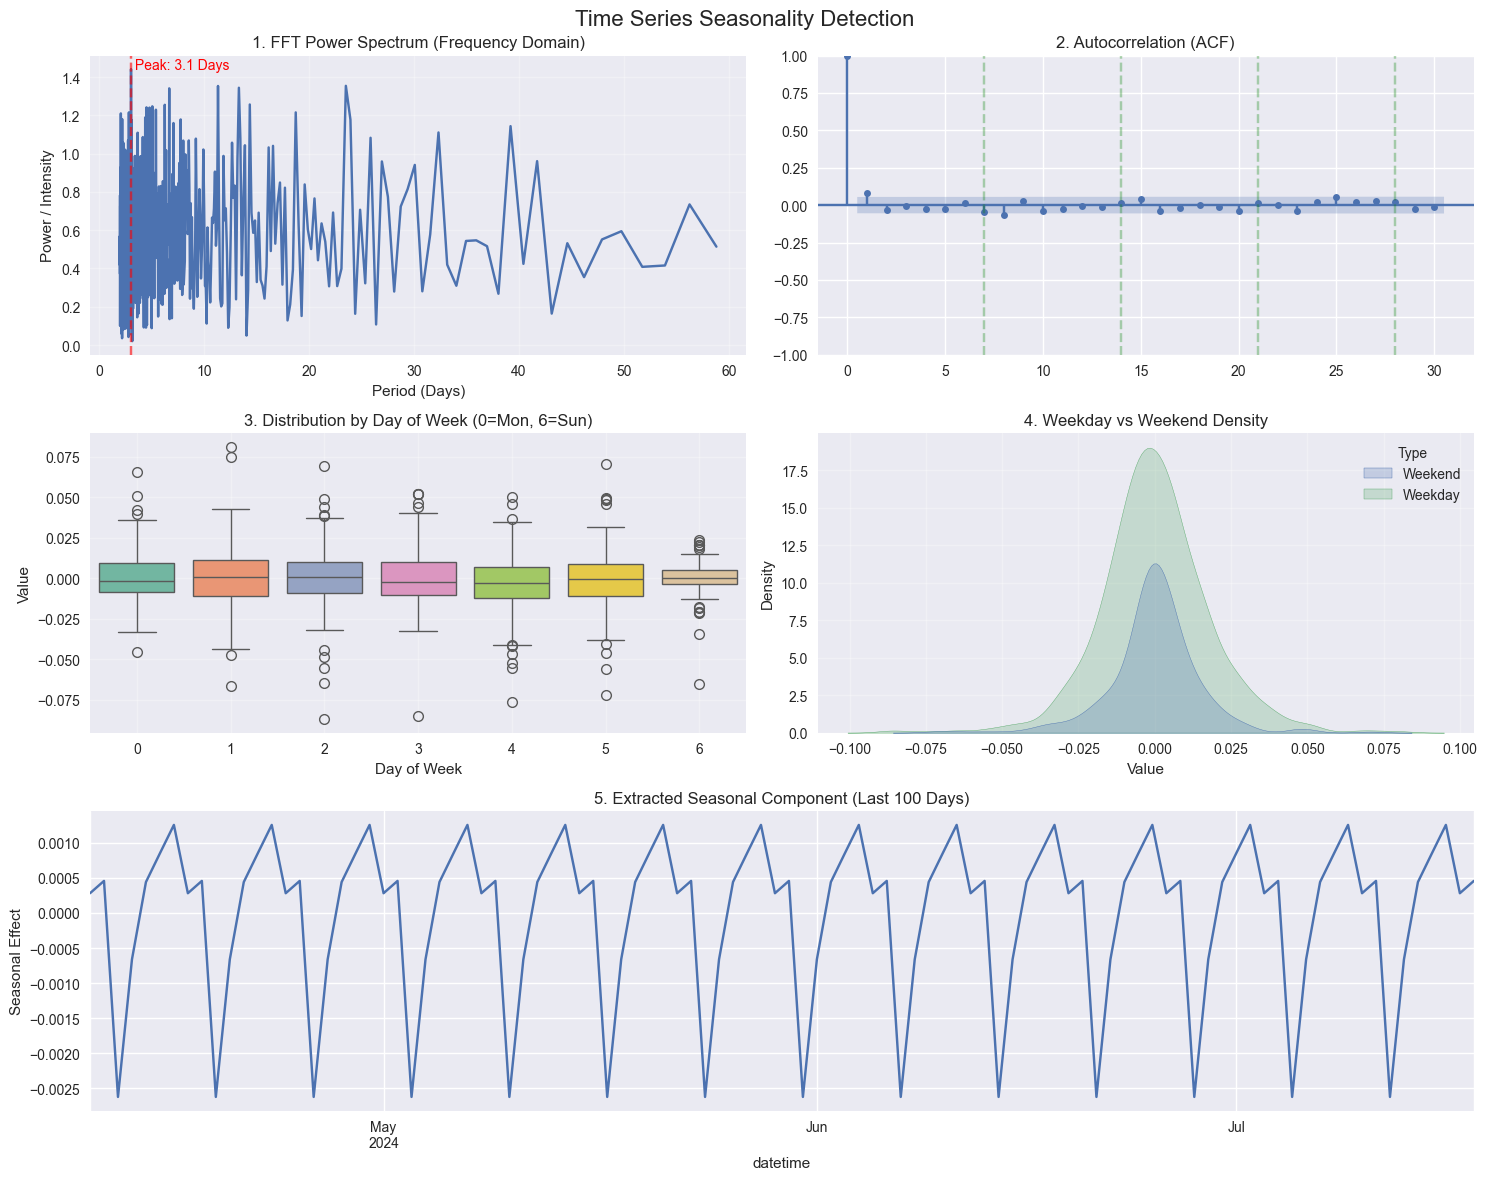

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq

def analyze_seasonality(data: pd.Series, max_lag=30):
    """
    综合检测时间序列的季节性
    :param data: Pandas Series (索引必须是 DatetimeIndex)
    :param max_lag: ACF 检测的最大滞后天数
    """
    
    # 确保数据没有 NaN
    data = data.dropna()
    
    # 创建画布
    fig = plt.figure(figsize=(15, 12))
    plt.suptitle(f'Time Series Seasonality Detection', fontsize=16)

    # ==========================================
    # 1. 频域分析: FFT (傅里叶变换)
    # ==========================================
    # 这一步是为了找出数据中"震动"能量最强的周期
    ax1 = plt.subplot(3, 2, 1)
    
    # 去趋势 (FFT 对平稳数据效果更好)
    detrended = data - data.mean()
    n = len(detrended)
    
    # 计算 FFT
    yf = fft(detrended.values)
    xf = fftfreq(n, 1)  # 假设采样频率为 1 (每天)
    
    # 取前半部分 (正频率)
    yf = np.abs(yf[:n//2])
    xf = xf[:n//2]
    
    # 将频率转换为周期 (Period = 1 / Frequency)
    # 忽略频率为 0 的直流分量，并避免除以 0
    with np.errstate(divide='ignore'):
        periods = 1 / xf
    
    # 绘制功率谱 (排除极低频/长趋势，只看 2天 到 60天 的周期)
    mask = (periods >= 2) & (periods <= 60)
    ax1.plot(periods[mask], yf[mask])
    ax1.set_title('1. FFT Power Spectrum (Frequency Domain)')
    ax1.set_xlabel('Period (Days)')
    ax1.set_ylabel('Power / Intensity')
    ax1.grid(True, alpha=0.3)
    
    # 标注最强周期
    if len(yf[mask]) > 0:
        peak_idx = np.argmax(yf[mask])
        peak_period = periods[mask][peak_idx]
        ax1.axvline(x=peak_period, color='r', linestyle='--', alpha=0.6)
        ax1.text(peak_period, max(yf[mask]), f' Peak: {peak_period:.1f} Days', color='r')

    # ==========================================
    # 2. 时域分析: ACF (自相关)
    # ==========================================
    ax2 = plt.subplot(3, 2, 2)
    plot_acf(data, lags=max_lag, ax=ax2, title='2. Autocorrelation (ACF)')
    # 高亮 Lag 7, 14, 21, 28
    for lag in [7, 14, 21, 28]:
        if lag <= max_lag:
            ax2.axvline(x=lag, color='green', linestyle='--', alpha=0.3)

    # ==========================================
    # 3. 业务逻辑: 按“星期几”分组 (Day of Week)
    # ==========================================
    # 检查是否有“周末效应”
    ax3 = plt.subplot(3, 2, 3)
    df_viz = data.to_frame(name='Value')
    df_viz['DayOfWeek'] = df_viz.index.dayofweek  # 0=Mon, 6=Sun
    df_viz['Type'] = df_viz['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
    
    sns.boxplot(data=df_viz, x='DayOfWeek', y='Value', ax=ax3, palette="Set2")
    ax3.set_title('3. Distribution by Day of Week (0=Mon, 6=Sun)')
    ax3.set_xlabel('Day of Week')
    ax3.grid(True, alpha=0.3)

    # ==========================================
    # 4. 业务逻辑: 周末 vs 工作日 均值/波动对比
    # ==========================================
    ax4 = plt.subplot(3, 2, 4)
    sns.kdeplot(data=df_viz, x='Value', hue='Type', fill=True, ax=ax4)
    ax4.set_title('4. Weekday vs Weekend Density')
    ax4.grid(True, alpha=0.3)
    
    # ==========================================
    # 5. 经典分解: Seasonal Decompose (假设周期=7)
    # ==========================================
    ax5 = plt.subplot(3, 1, 3)
    # 注意: model='additive' 适用于加法模型，如果波动随数值变大则用 'multiplicative'
    # period=7 强制提取7天周期看残差
    try:
        res = seasonal_decompose(data, model='additive', period=7)
        res.seasonal.iloc[-100:].plot(ax=ax5) # 只画最后100天，看清楚点
        ax5.set_title('5. Extracted Seasonal Component (Last 100 Days)')
        ax5.set_ylabel('Seasonal Effect')
    except Exception as e:
        ax5.text(0.5, 0.5, f'Decomposition Failed: {str(e)}', ha='center')

    plt.tight_layout()
    plt.show()

# 使用方法：
analyze_seasonality(train_data['y'].diff().dropna()) # 建议传入差分后的数据或收益率数据

In [12]:
def find_best_sarima_model(train_series, fixed_d=1, fixed_D=0, p_range=(0, 1), q_range=(0, 1), P_range=(0, 1), Q_range=(0, 1), s_values=[7], enforce_stationarity=True, enforce_invertibility=True):
    p = range(p_range[0], p_range[1] + 1)
    q = range(q_range[0], q_range[1] + 1)
    P = range(P_range[0], P_range[1] + 1)
    Q = range(Q_range[0], Q_range[1] + 1)

    non_seasonal_params = list(itertools.product(p, [fixed_d], q))
    seasonal_PQD = list(itertools.product(P, [fixed_D], Q))

    best_aic = np.inf
    best_params = None
    best_model = None

    warnings.filterwarnings("ignore")
    
    total_iterations = len(non_seasonal_params) * len(seasonal_PQD) * len(s_values)
    current_iteration = 0

    for (p_val, d_val, q_val) in non_seasonal_params:
        order = (p_val, d_val, q_val)
        
        for (P_val, D_val, Q_val) in seasonal_PQD:
            
            for s_val in s_values:
                seasonal_order = (P_val, D_val, Q_val, s_val)
                current_iteration += 1
                
                try:
                    model = SARIMAX(
                        train_series,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=enforce_stationarity,
                        enforce_invertibility=enforce_invertibility
                    )
                    results = model.fit(disp=False)
                    current_aic = results.aic

                    if current_aic < best_aic:
                        best_aic = current_aic
                        best_model = results
                        best_params = {
                            'order': order,
                            'seasonal_order': seasonal_order,
                            'AIC': best_aic
                        }

                except:
                    continue
                    
    warnings.filterwarnings("default")

    if best_model is None:
        print("未找到可成功擬合的模型。")
        return None, None
        
    print(f"最佳 SARIMA 參數: {best_params['order']} x {best_params['seasonal_order']}")
    print(f"最低 AIC: {best_params['AIC']:.4f}")

    return best_model, best_params


best_model, best_params = find_best_sarima_model(
    train_data['y'],
    fixed_d=1,     
    fixed_D=0,     
    p_range=(0, 4), 
    q_range=(0, 4),  
    P_range=(0, 2), 
    Q_range=(0, 2), 
    s_values=[7]   
)

最佳 SARIMA 參數: (0, 1, 1) x (1, 0, 0, 7)
最低 AIC: -6859.1980


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def check_model_overfitting(data, test_days=30):
    """
    对比 SARIMA (0,1,1)x(1,0,0,7) 和 ARIMA (0,1,1)
    data: 时间序列数据 (Series)
    test_days: 用于回测的最近天数 (比如最近30天)
    """
    
    # 划分训练集和测试集
    train = data[:-test_days]
    test = data[-test_days:]
    
    print(f"--- 数据集划分 ---")
    print(f"训练集长度: {len(train)}, 测试集长度: {len(test)}")
    print("-" * 30)

    # ==========================================
    # 模型 A: 你的复杂模型 SARIMA (带季节性)
    #Params: (0, 1, 1) x (1, 0, 0, 7)
    # ==========================================
    print("正在拟合模型 A: SARIMA(0,1,1)x(1,0,0,7)...")
    model_complex = sm.tsa.statespace.SARIMAX(
        train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res_complex = model_complex.fit(disp=False)
    
    # 预测
    pred_complex = res_complex.get_forecast(steps=len(test))
    rmse_complex = np.sqrt(mean_squared_error(test, pred_complex.predicted_mean))

    # ==========================================
    # 模型 B: 基准模型 ARIMA (去掉季节性，做对比)
    # Params: (0, 1, 1) x (0, 0, 0, 0) -> 即普通 ARIMA
    # ==========================================
    print("正在拟合模型 B: ARIMA(0,1,1) (无季节性)...")
    model_simple = sm.tsa.statespace.SARIMAX(
        train,
        order=(0, 1, 1),
        seasonal_order=(0, 0, 0, 0), # 强制去掉季节性
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res_simple = model_simple.fit(disp=False)
    
    # 预测
    pred_simple = res_simple.get_forecast(steps=len(test))
    rmse_simple = np.sqrt(mean_squared_error(test, pred_simple.predicted_mean))

    # ==========================================
    # 3. 结果分析报告
    # ==========================================
    print("\n" + "="*40)
    print(">>> 过拟合检测报告 <<<")
    print("="*40)
    
    # 1. 检查季节性参数的 P值
    # 我们需要看 ar.S.L7 这一项
    pvalues = res_complex.pvalues
    seasonal_p = pvalues.get('ar.S.L7', None)
    
    print(f"\n1. 季节性参数显著性 (P-value):")
    if seasonal_p is not None:
        print(f"   P值: {seasonal_p:.4f}")
        if seasonal_p > 0.05:
            print("   🔴 结论: 不显著 (P > 0.05)。")
            print("      这意味着那个7天的周期性可能是噪音，模型在‘强行’拟合。")
        else:
            print("   🟢 结论: 显著 (P < 0.05)。")
            print("      统计学上确实存在微弱的7天周期效应。")
    else:
        print("   未找到季节性参数，请检查模型结构。")

    # 2. 比较 AIC (训练集上的表现)
    print(f"\n2. AIC 对比 (越低越好):")
    print(f"   SARIMA (复杂): {res_complex.aic:.2f}")
    print(f"   ARIMA  (简单): {res_simple.aic:.2f}")
    if res_complex.aic < res_simple.aic:
        print("   -> AIC 认为 SARIMA 更好 (这也是之前自动选出它的原因)。")
    else:
        print("   -> AIC 认为简单模型更好。")

    # 3. 比较 RMSE (测试集上的表现 - 真实战场)
    print(f"\n3. 样本外预测误差 (RMSE) - 关键指标:")
    print(f"   SARIMA (复杂): {rmse_complex:.6f}")
    print(f"   ARIMA  (简单): {rmse_simple:.6f}")
    
    diff_pct = (rmse_complex - rmse_simple) / rmse_simple * 100
    
    print(f"\n>>> 最终判决 <<<")
    if rmse_complex > rmse_simple:
        print(f"🔴 发生过拟合！(Overfitting)")
        print(f"   复杂模型的预测误差反而比简单模型高了 {diff_pct:.2f}%。")
        print("   建议：放弃季节性参数，使用 ARIMA(0,1,1)。")
    elif seasonal_p > 0.05:
         print(f"🟠 疑似过拟合/无意义复杂度。")
         print(f"   虽然误差差不多，但季节性参数不显著。根据奥卡姆剃刀原则，建议选简单的 ARIMA。")
    else:
        print(f"🟢 模型有效！")
        print(f"   SARIMA 在新数据上的表现优于简单模型，且参数显著。")
        print("   那个看起来不明显的季节性确实提供了预测价值。")

data = train_data['y']
check_model_overfitting(train_data)

--- 数据集划分 ---
训练集长度: 1265, 测试集长度: 30
------------------------------
正在拟合模型 A: SARIMA(0,1,1)x(1,0,0,7)...
正在拟合模型 B: ARIMA(0,1,1) (无季节性)...

>>> 过拟合检测报告 <<<

1. 季节性参数显著性 (P-value):
   P值: 0.0520
   🔴 结论: 不显著 (P > 0.05)。
      这意味着那个7天的周期性可能是噪音，模型在‘强行’拟合。

2. AIC 对比 (越低越好):
   SARIMA (复杂): -6646.69
   ARIMA  (简单): -6676.51
   -> AIC 认为简单模型更好。

3. 样本外预测误差 (RMSE) - 关键指标:
   SARIMA (复杂): 0.054244
   ARIMA  (简单): 0.052946

>>> 最终判决 <<<
🔴 发生过拟合！(Overfitting)
   复杂模型的预测误差反而比简单模型高了 2.45%。
   建议：放弃季节性参数，使用 ARIMA(0,1,1)。


C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` inst

Training set length: 1295
Test set length: 324
Training period: 2021-01-01 00:00:00 to 2024-07-18 00:00:00
Test period: 2024-07-19 00:00:00 to 2025-06-07 00:00:00

Running Static Forecast...
--- 1. Static Forecast ---
Static forecast completed
Running Quasi-Dynamic Forecast...
--- 2. Quasi-Dynamic Forecast ---


C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

Quasi-dynamic forecast completed
Running Dynamic Forecast...
--- 3. Dynamic Retraining Forecast ---


C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\30459\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\30459\AppData\Local\Packages

Dynamic forecast completed

Forecasting Results Comparison (SARIMA(0, 1, 1)x(1, 0, 0, 7))
                 RMSE     MAE    MAPE    MASE
Static         0.0569  0.0496  5.3694  5.1816
Quasi-Dynamic  0.0134  0.0095  1.0436  0.9963
Dynamic        0.0134  0.0095  1.0440  0.9966

Generating forecast plots...


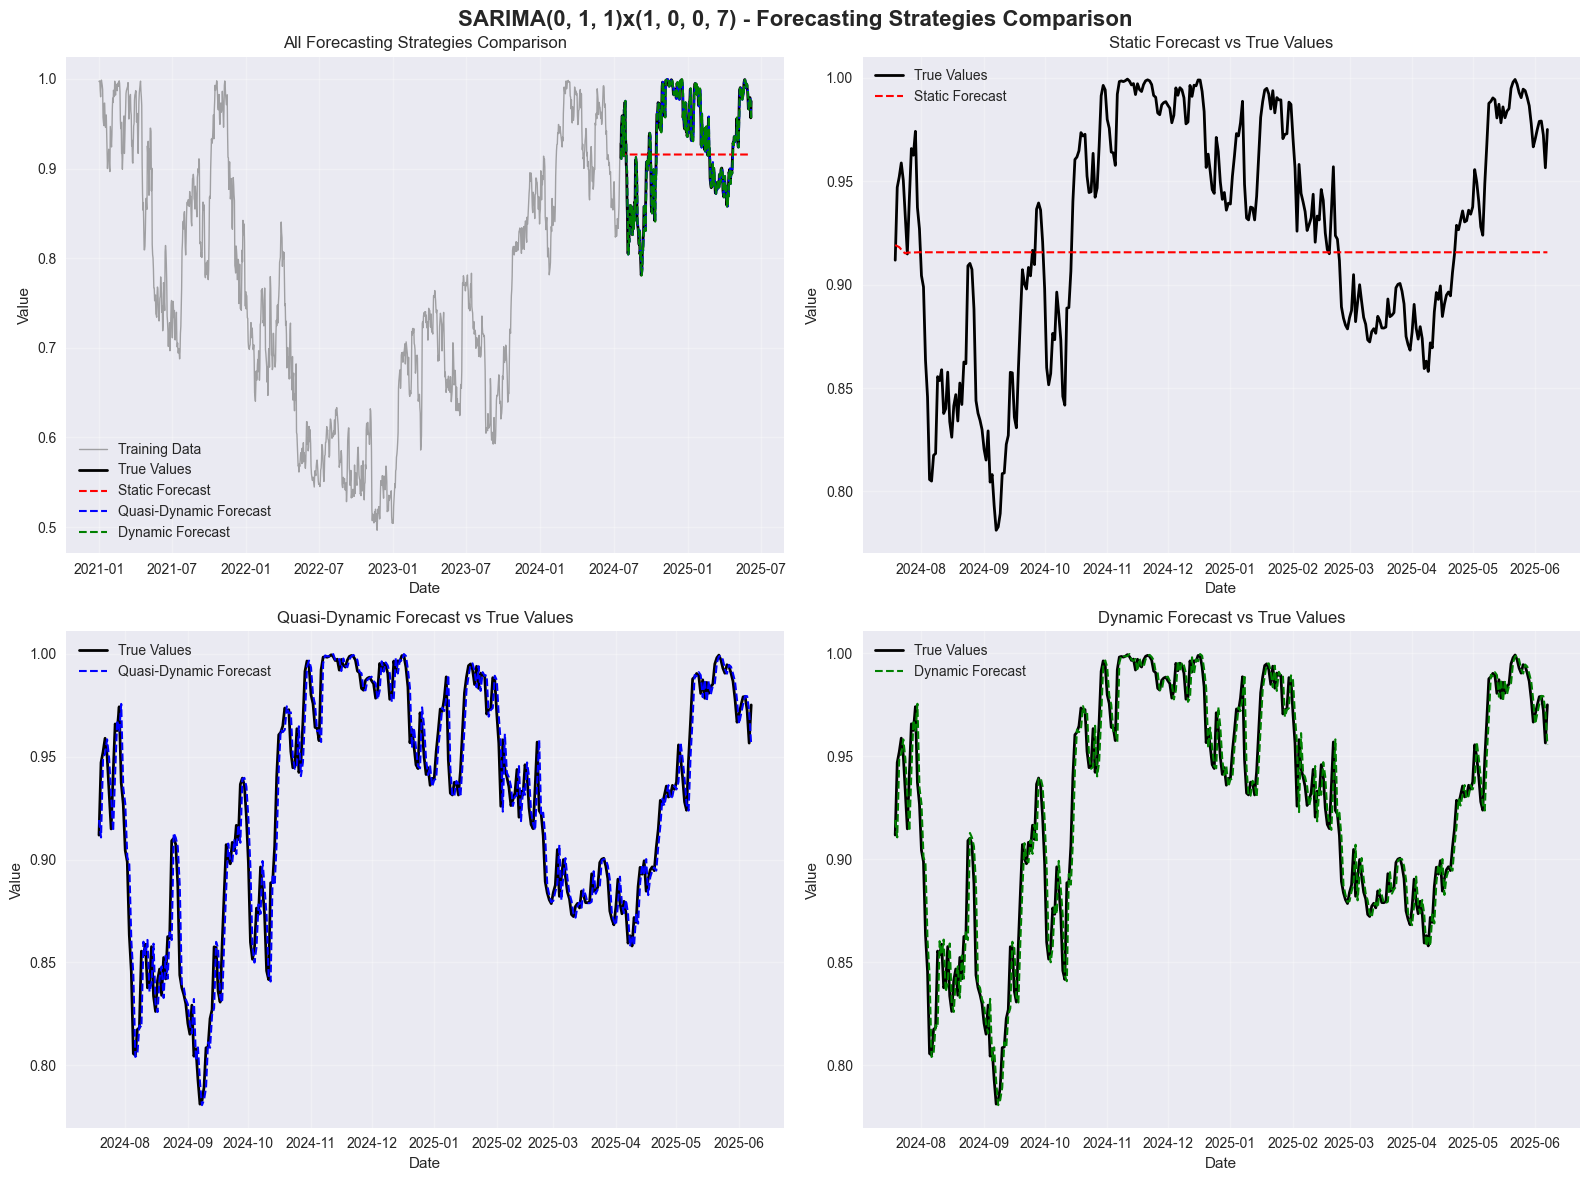

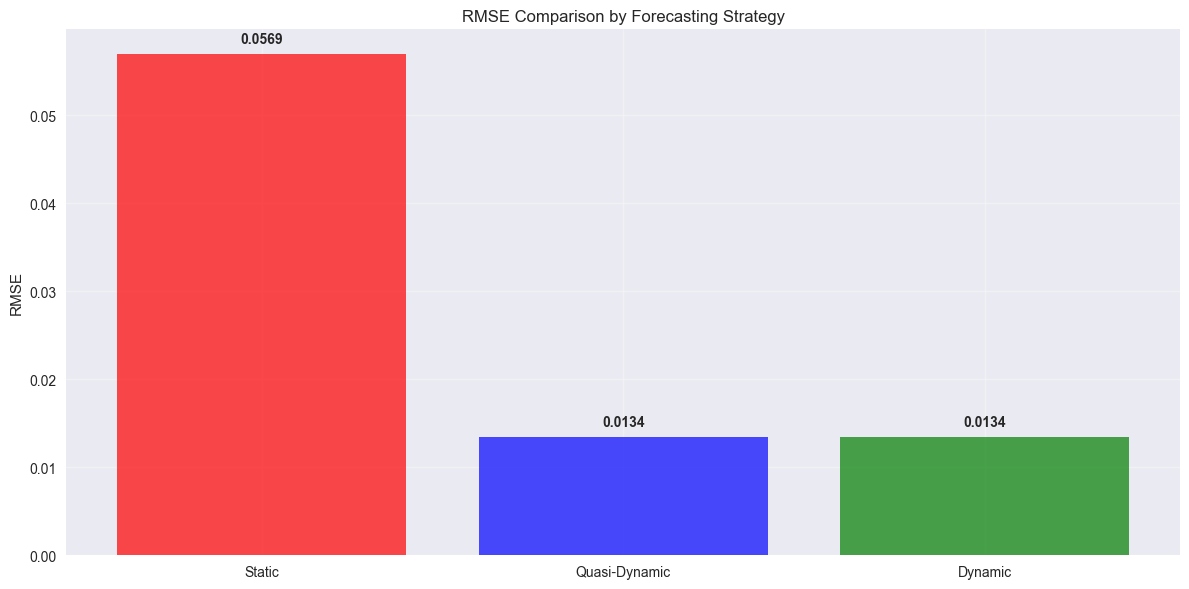

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from typing import Tuple, Dict, List

def calculate_metrics(y_true: pd.Series, y_pred: pd.Series, model_fit: object) -> Dict[str, float]:
    aligned_index = y_pred.index.intersection(y_true.index)
    y_true_aligned = y_true.loc[aligned_index]
    y_pred_aligned = y_pred.loc[aligned_index]
    
    if len(y_true_aligned) == 0:
        return {
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'MASE': np.nan
        }
    
    _rmse = rmse(y_true_aligned, y_pred_aligned)
    _mae = mean_absolute_error(y_true_aligned, y_pred_aligned)
    
    y_true_nonzero = y_true_aligned.replace(0, np.nan)
    if y_true_nonzero.isna().all():
        _mape = np.nan
    else:
        _mape = np.mean(np.abs((y_true_aligned - y_pred_aligned) / y_true_nonzero.fillna(0.000001))) * 100
    
    numerator = _mae
    y_diff = y_true_aligned.diff().dropna()
    denominator = np.mean(np.abs(y_diff)) if len(y_diff) > 0 else np.nan
    _mase = numerator / denominator if denominator != 0 and not np.isnan(denominator) else np.nan

    return {
        'RMSE': _rmse,
        'MAE': _mae,
        'MAPE': _mape,
        'MASE': _mase
    }

ORDER = (0, 1, 1)
SEASONAL_ORDER = (1, 0, 0, 7)

def predict_static(train: pd.Series, test: pd.Series) -> Tuple[pd.Series, object]:
    print("--- 1. Static Forecast ---")
    
    model = SARIMAX(train, order=ORDER, seasonal_order=SEASONAL_ORDER)
    model_fit = model.fit(disp=False)
    
    start = len(train)
    end = len(train) + len(test) - 1
    
    predictions = model_fit.predict(start=start, end=end)
    predictions.index = test.index
    
    return predictions, model_fit

def predict_quasi_dynamic(train: pd.Series, test: pd.Series) -> Tuple[pd.Series, object]:
    print("--- 2. Quasi-Dynamic Forecast ---")
    
    model = SARIMAX(train, order=ORDER, seasonal_order=SEASONAL_ORDER)
    model_fit = model.fit(disp=False)
    
    predictions = []
    
    for t in range(len(test)):
        forecast = model_fit.forecast(steps=1)
        yhat = forecast.iloc[0]
        predictions.append(yhat)
        
        if t < len(test) - 1:
            new_obs = test.iloc[t]
            model_fit = model_fit.extend([new_obs])
    
    predictions_series = pd.Series(predictions, index=test.index)
    return predictions_series, model_fit

def predict_dynamic_retrain(train: pd.Series, test: pd.Series) -> Tuple[pd.Series, object]:
    print("--- 3. Dynamic Retraining Forecast ---")
    
    history = train.copy().tolist()
    predictions = []
    model_fit = None
    
    for t in range(len(test)):
        current_series = pd.Series(history)
        model = SARIMAX(current_series, order=ORDER, seasonal_order=SEASONAL_ORDER)
        model_fit = model.fit(disp=False)
        
        forecast = model_fit.forecast(steps=1)
        yhat = forecast.iloc[0]
        predictions.append(yhat)
        
        obs = test.iloc[t]
        history.append(obs)
    
    predictions_series = pd.Series(predictions, index=test.index)
    return predictions_series, model_fit

def plot_predictions_comparison(train: pd.Series, test: pd.Series, predictions_dict: Dict, results_df: pd.DataFrame):
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'SARIMA{ORDER}x{SEASONAL_ORDER} - Forecasting Strategies Comparison', fontsize=16, fontweight='bold')
    
    colors = {'Static': 'red', 'Quasi-Dynamic': 'blue', 'Dynamic': 'green', 'True': 'black'}
    
    ax1 = axes[0, 0]
    ax1.plot(train.index, train.values, color='gray', alpha=0.7, label='Training Data', linewidth=1)
    ax1.plot(test.index, test.values, color=colors['True'], label='True Values', linewidth=2)
    for strategy, pred in predictions_dict.items():
        ax1.plot(pred.index, pred.values, color=colors[strategy], 
                label=f'{strategy} Forecast', linewidth=1.5, linestyle='--')
    ax1.set_title('All Forecasting Strategies Comparison')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    ax2.plot(test.index, test.values, color=colors['True'], label='True Values', linewidth=2)
    if 'Static' in predictions_dict:
        ax2.plot(predictions_dict['Static'].index, predictions_dict['Static'].values, 
                color=colors['Static'], label='Static Forecast', linewidth=1.5, linestyle='--')
    ax2.set_title('Static Forecast vs True Values')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[1, 0]
    ax3.plot(test.index, test.values, color=colors['True'], label='True Values', linewidth=2)
    if 'Quasi-Dynamic' in predictions_dict:
        ax3.plot(predictions_dict['Quasi-Dynamic'].index, predictions_dict['Quasi-Dynamic'].values, 
                color=colors['Quasi-Dynamic'], label='Quasi-Dynamic Forecast', linewidth=1.5, linestyle='--')
    ax3.set_title('Quasi-Dynamic Forecast vs True Values')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Value')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    ax4.plot(test.index, test.values, color=colors['True'], label='True Values', linewidth=2)
    if 'Dynamic' in predictions_dict:
        ax4.plot(predictions_dict['Dynamic'].index, predictions_dict['Dynamic'].values, 
                color=colors['Dynamic'], label='Dynamic Forecast', linewidth=1.5, linestyle='--')
    ax4.set_title('Dynamic Forecast vs True Values')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    fig2, ax5 = plt.subplots(figsize=(12, 6))
    
    strategies = list(predictions_dict.keys())
    rmse_values = []
    
    for strategy in strategies:
        if strategy in results_df.index:
            rmse_val = results_df.loc[strategy, 'RMSE']
            rmse_values.append(rmse_val)
    
    bars = ax5.bar(strategies, rmse_values, color=[colors[s] for s in strategies], alpha=0.7)
    ax5.set_title('RMSE Comparison by Forecasting Strategy')
    ax5.set_ylabel('RMSE')
    ax5.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, rmse_values):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_sarima_comparison(train: pd.Series, test: pd.Series):
    print(f"Training set length: {len(train)}")
    print(f"Test set length: {len(test)}")
    print(f"Training period: {train.index.min()} to {train.index.max()}")
    print(f"Test period: {test.index.min()} to {test.index.max()}\n")

    results = {}
    models = {}
    predictions_dict = {}
    
    try:
        print("Running Static Forecast...")
        y_pred_static, model_static = predict_static(train, test)
        metrics_static = calculate_metrics(test, y_pred_static, model_static)
        results['Static'] = metrics_static
        models['Static'] = model_static
        predictions_dict['Static'] = y_pred_static
        print("Static forecast completed")
        
        print("Running Quasi-Dynamic Forecast...")
        y_pred_quasi, model_quasi = predict_quasi_dynamic(train, test)
        metrics_quasi = calculate_metrics(test, y_pred_quasi, model_quasi)
        results['Quasi-Dynamic'] = metrics_quasi
        models['Quasi-Dynamic'] = model_quasi
        predictions_dict['Quasi-Dynamic'] = y_pred_quasi
        print("Quasi-dynamic forecast completed")
        
        print("Running Dynamic Forecast...")
        y_pred_dynamic, model_dynamic = predict_dynamic_retrain(train, test)
        metrics_dynamic = calculate_metrics(test, y_pred_dynamic, model_dynamic)
        results['Dynamic'] = metrics_dynamic
        models['Dynamic'] = model_dynamic
        predictions_dict['Dynamic'] = y_pred_dynamic
        print("Dynamic forecast completed")
        
    except Exception as e:
        print(f"Error in forecasting: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

    print("\n" + "=" * 60)
    print(f"Forecasting Results Comparison (SARIMA{ORDER}x{SEASONAL_ORDER})")
    print("=" * 60)
    
    results_df = pd.DataFrame(results).T
    print(results_df.round(4))
    
    print("\nGenerating forecast plots...")
    plot_predictions_comparison(train, test, predictions_dict, results_df)
    
    return results_df, models, predictions_dict

train_series = train_data['y'].asfreq('D')
test_series = test_data['y'].asfreq('D')

if not isinstance(train_series.index, pd.DatetimeIndex):
    train_series.index = pd.to_datetime(train_series.index)
    test_series.index = pd.to_datetime(test_series.index)

results_df, models_dict, predictions_dict = run_sarima_comparison(train_series, test_series)

In [ ]:
# # 检验空值和inf
# print("数据基本信息：")
# print(data.info())
# print("\n" + "="*50)

# # 检查空值
# print("空值检查：")
# print(f"总空值数量: {data['y'].isnull().sum()}")
# print(f"空值比例: {data['y'].isnull().mean():.4f}")

# # 检查无穷值
# print("\n无穷值检查：")
# print(f"正无穷值数量: {np.isinf(data['y']).sum()}")
# print(f"负无穷值数量: {np.isinf(-data['y']).sum()}")

# # 检查数据的统计信息
# print("\n数据统计信息：")
# print(data['y'].describe())

# # 检查是否有异常值（可选）
# print("\n数据范围检查：")
# print(f"最小值: {data['y'].min()}")
# print(f"最大值: {data['y'].max()}")

# # 如果发现空值或无穷值，进行清理
# if data['y'].isnull().sum() > 0 or np.isinf(data['y']).sum() > 0:
#     print("\n正在清理数据...")
#     initial_count = len(data)
#     # 删除空值
#     data = data.dropna()
#     # 删除无穷值
#     data = data[np.isfinite(data['y'])]
#     final_count = len(data)
#     print(f"数据清理完成，删除了 {initial_count - final_count} 行异常数据")
    
# print(f"\n最终数据行数: {len(data)}")
# print(data.head())

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1619 entries, 2021-01-01 to 2025-06-07
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1619 non-null   float64
dtypes: float64(1)
memory usage: 25.3 KB
None

空值检查：
总空值数量: 0
空值比例: 0.0000

无穷值检查：
正无穷值数量: 0
负无穷值数量: 0

数据统计信息：
count    1619.000000
mean        0.795325
std         0.145610
min         0.496519
25%         0.680093
50%         0.815139
75%         0.928251
max         0.999438
Name: y, dtype: float64

数据范围检查：
最小值: 0.49651936001734986
最大值: 0.999437900139048

最终数据行数: 1619
                   y
datetime            
2021-01-01  0.997053
2021-01-02  0.997710
2021-01-03  0.997698
2021-01-04  0.987365
2021-01-05  0.980055
